In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
import torchmetrics
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import StratifiedKFold

import medmnist
from medmnist import INFO, Evaluator

In [2]:
data_flag = 'dermamnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
print(info['label'])

{'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def preTrainImageNet(model_name):
    data_transforms = get_transforms()
    
    BATCH_SIZE = 128
    
    sets = ['train','test']
    image_datasets = {x:DataClass(split=x, transform=data_transforms[x], download=True, size=128)
                    for x in ['train','test']}
    # dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
    #                                             shuffle=True,num_workers=0)
    #                 for x in ['train','test']}

    dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'],batch_size=BATCH_SIZE,
                                                shuffle=True,num_workers=0),
                   'test': torch.utils.data.DataLoader(image_datasets['test'],batch_size=2*BATCH_SIZE,
                                                shuffle=True,num_workers=0)
                  }
    
    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','test']}
    
    
    pretrained_model_ImageNet = models.squeezenet1_1(pretrained=True)
    
    #freezing previous layers
    for param in pretrained_model_ImageNet.features.parameters():
        param.requires_grad = False
    
    #exchange the last layer
    num_classes = 2
    
    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'squeezenet':
        # Newly created modules have require_grad=True by default
        num_features = pretrained_model_ImageNet.classifier[1].in_channels
        features = list(pretrained_model_ImageNet.classifier.children())[:-3] # Remove last 3 layers
        features.extend([nn.Conv2d(num_features, num_classes, kernel_size=1)]) # Add
        features.extend([nn.ReLU(inplace=True)]) # Add
        features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
        pretrained_model_ImageNet.classifier = nn.Sequential(*features)
    
    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")
    
    pretrained_model_ImageNet.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.01)
    
    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    
    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, 
                                    dataloaders, dataset_sizes, num_classes, num_epochs=25)

In [5]:
def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_classes=3, num_epochs=25):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        labels = labels.squeeze().long()
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'test':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=num_classes)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=num_classes)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=num_classes)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=num_classes, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt_dir = './plots'
    
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(plt_dir+'/accuracy_curves/'+ f'fold_{fold_num}.png')

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig(plt_dir+'/loss_curves/'+ f'fold_{fold_num}.png')

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    metrics['time'] = time_elapsed
    metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)


    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


In [6]:
def print_metrics(metrics):
  #total_time = metrics["time"]*5
  print(f'Average accuracy: {metrics["accuracy"]:.4f}')
  print(f'Average precision: {metrics["precision"]:.4f}')
  print(f'Average recall: {metrics["recall"]:.4f}')
  print(f'Average F1 score: {metrics["f1"]:.4f}')
  print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
  print(f'Memory Usage: {metrics["memory"]:.4f} MiB')

In [7]:
def get_transforms():
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    data_transforms = {
          'train':transforms.Compose([
              # transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'test':transforms.Compose([
              # transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
    return data_transforms

Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\breastmnist_128.npz
Epoch 0/24
----------
train Loss: 0.5854 Acc: 0.7070
test Loss: 0.5430 Acc: 0.7308

Epoch 1/24
----------
train Loss: 0.5576 Acc: 0.7234
test Loss: 0.5069 Acc: 0.8013

Epoch 2/24
----------
train Loss: 0.5206 Acc: 0.7546
test Loss: 0.4941 Acc: 0.7692

Epoch 3/24
----------
train Loss: 0.5007 Acc: 0.7802
test Loss: 0.4960 Acc: 0.7885

Epoch 4/24
----------
train Loss: 0.4971 Acc: 0.7784
test Loss: 0.4823 Acc: 0.7821

Epoch 5/24
----------
train Loss: 0.4803 Acc: 0.7912
test Loss: 0.4377 Acc: 0.8526

Epoch 6/24
----------
train Loss: 0.4781 Acc: 0.7912
test Loss: 0.4285 Acc: 0.8526

Epoch 7/24
----------
train Loss: 0.4792 Acc: 0.8040
test Loss: 0.4262 Acc: 0.8590

Epoch 8/24
----------
train Loss: 0.4546 Acc: 0.8114
test Loss: 0.4251 Acc: 0.8590

Epoch 9/24
----------
train Loss: 0.4577 Acc: 0.8004
test Loss: 0.4236 Acc: 0.8590

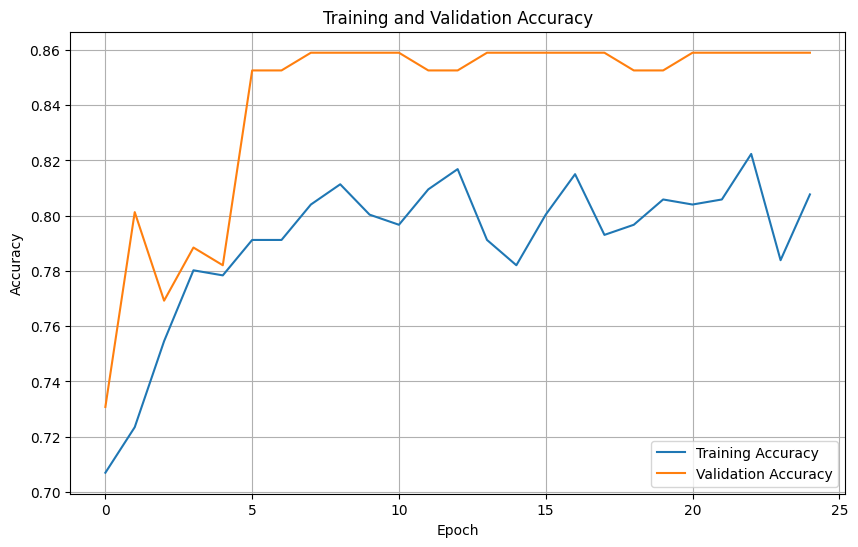

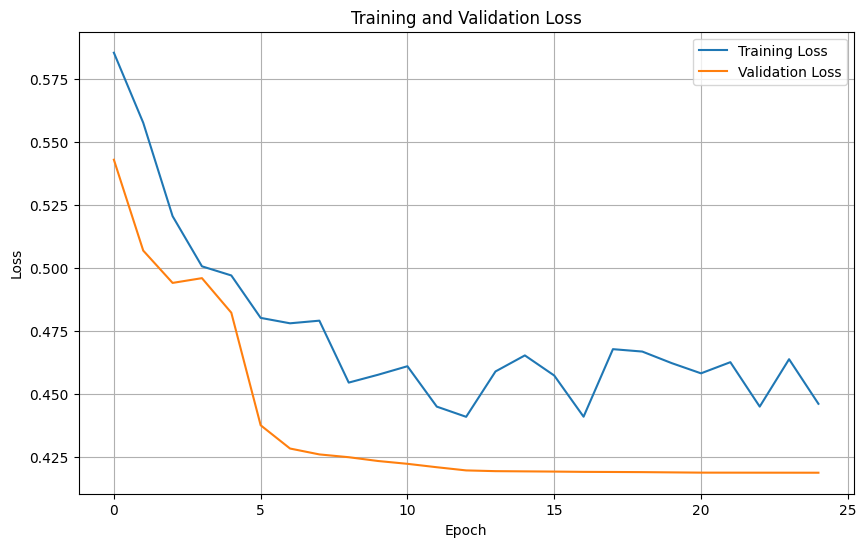

In [45]:
preTrainImageNet("squeezenet") #breastmnist (128x128)

Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\pneumoniamnist_128.npz
Epoch 0/24
----------
train Loss: 0.3748 Acc: 0.8290
test Loss: 0.3145 Acc: 0.8718

Epoch 1/24
----------
train Loss: 0.3130 Acc: 0.8598
test Loss: 0.2568 Acc: 0.8958

Epoch 2/24
----------
train Loss: 0.2742 Acc: 0.8800
test Loss: 0.2449 Acc: 0.9022

Epoch 3/24
----------
train Loss: 0.2717 Acc: 0.8868
test Loss: 0.2608 Acc: 0.8894

Epoch 4/24
----------
train Loss: 0.2514 Acc: 0.8917
test Loss: 0.2294 Acc: 0.9038

Epoch 5/24
----------
train Loss: 0.2561 Acc: 0.8859
test Loss: 0.3507 Acc: 0.8574

Epoch 6/24
----------
train Loss: 0.2496 Acc: 0.8866
test Loss: 0.2728 Acc: 0.8798

Epoch 7/24
----------
train Loss: 0.2297 Acc: 0.9065
test Loss: 0.2345 Acc: 0.8974

Epoch 8/24
----------
train Loss: 0.2332 Acc: 0.9012
test Loss: 0.2362 Acc: 0.8990

Epoch 9/24
----------
train Loss: 0.2316 Acc: 0.9006
test Loss: 0.2315 Acc: 

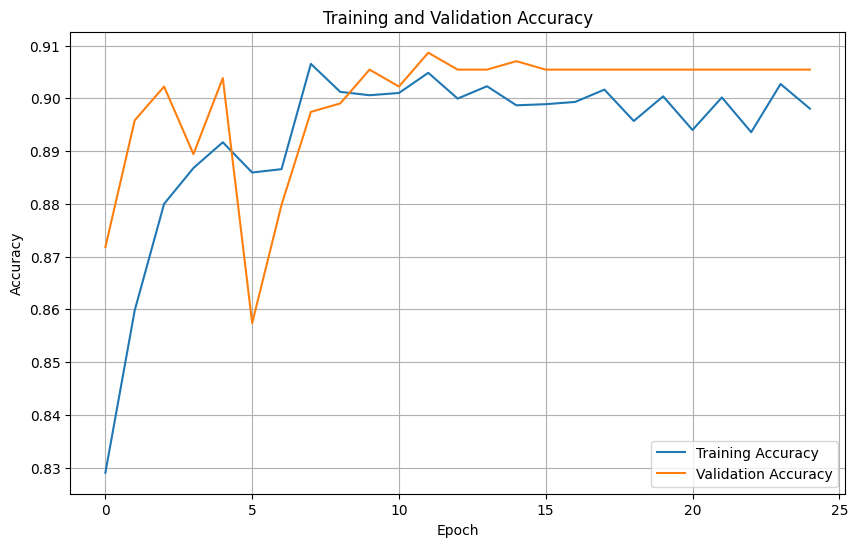

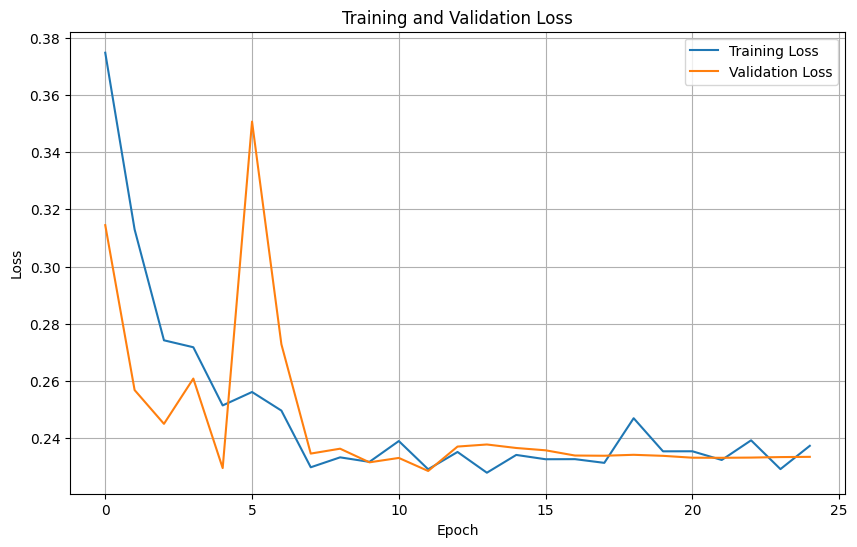

In [52]:
preTrainImageNet("squeezenet") #pneumoniamnist (128x128)

In [8]:
preTrainImageNet("squeezenet") #dermamnist (128x128)

Using downloaded and verified file: C:\Users\ishmu\.medmnist\dermamnist_128.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\dermamnist_128.npz


C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)

['Bluetooth', 'Humidity', 'Transistor']


In [7]:
def preTrainImageNet(model_name, classes):
  data_transforms = get_transforms()
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      folder_path = './THB_dataset'
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
    train_FileNames = [all_filenames[idx] for idx in train_idx]
    val_FileNames = [all_filenames[idx] for idx in test_idx]
    print('Fold: ',i)
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    fold_dir = f'./splitted_dataset/fold{i}'
    if not os.path.exists(fold_dir):
        os.makedirs(fold_dir+'/train')
        os.makedirs(fold_dir+'/val')

        # Creating the class folders in train and validation folders
        for class_name in classes:
            os.makedirs(fold_dir+'/train/' + class_name)
            os.makedirs(fold_dir+'/val/' + class_name)
    
        for name in train_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/train/' + class_name)
        for name in val_FileNames:
            name_split = name.split('\\')
            class_name = name_split[1] + '/' + name_split[2]
            shutil.copy(name, fold_dir+'/val/' + class_name)


    sets = ['train','val']
    image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                            data_transforms[x])
                    for x in ['train','val']}
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                shuffle=True,num_workers=0)
                    for x in ['train','val']}

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


    pretrained_model_ImageNet = models.squeezenet1_1(pretrained=True)

    #freezing previous layers
    for param in pretrained_model_ImageNet.features.parameters():
        param.requires_grad = False

    #exchange the last layer
    num_classes = 3

    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'squeezenet':
        # Newly created modules have require_grad=True by default
        num_features = pretrained_model_ImageNet.classifier[1].in_channels
        features = list(pretrained_model_ImageNet.classifier.children())[:-3] # Remove last 3 layers
        features.extend([nn.Conv2d(num_features, num_classes, kernel_size=1)]) # Add
        features.extend([nn.ReLU(inplace=True)]) # Add
        features.extend([nn.AdaptiveAvgPool2d(output_size=(1,1))]) # Add
        pretrained_model_ImageNet.classifier = nn.Sequential(*features)

    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")

    pretrained_model_ImageNet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.001)

    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, dataloaders, dataset_sizes, i, num_epochs=25)

    all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)
  # print_performance()

Using downloaded and verified file: C:\Users\ishmu\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\ishmu\.medmnist\dermamnist.npz
Epoch 0/24
----------
train Loss: 2.0002 Acc: 0.4156
test Loss: 1.1083 Acc: 0.6334

Epoch 1/24
----------
train Loss: 1.3403 Acc: 0.5770
test Loss: 1.3682 Acc: 0.4718

Epoch 2/24
----------
train Loss: 1.2826 Acc: 0.6027
test Loss: 1.1721 Acc: 0.6075

Epoch 3/24
----------
train Loss: 1.2394 Acc: 0.6157
test Loss: 1.4193 Acc: 0.5287

Epoch 4/24
----------
train Loss: 1.2250 Acc: 0.6222
test Loss: 1.1075 Acc: 0.6539

Epoch 5/24
----------
train Loss: 1.2377 Acc: 0.6177
test Loss: 1.1585 Acc: 0.6569

Epoch 6/24
----------
train Loss: 1.2576 Acc: 0.6152
test Loss: 1.1271 Acc: 0.6559

Epoch 7/24
----------
train Loss: 1.1528 Acc: 0.6308
test Loss: 1.0685 Acc: 0.6434

Epoch 8/24
----------
train Loss: 1.1389 Acc: 0.6355
test Loss: 1.0646 Acc: 0.6464

Epoch 9/24
----------
train Loss: 1.1384 Acc: 0.6349
test Loss: 1.0633 Acc: 0.6489

Epoch 10

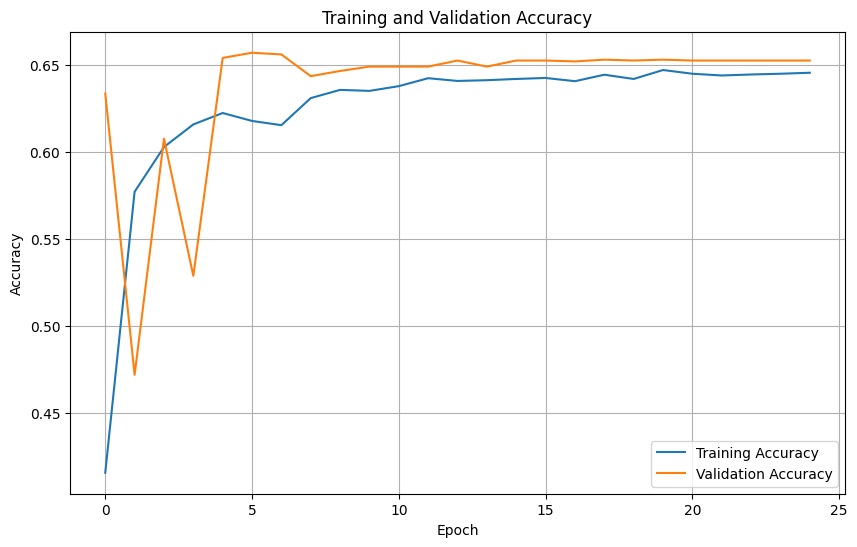

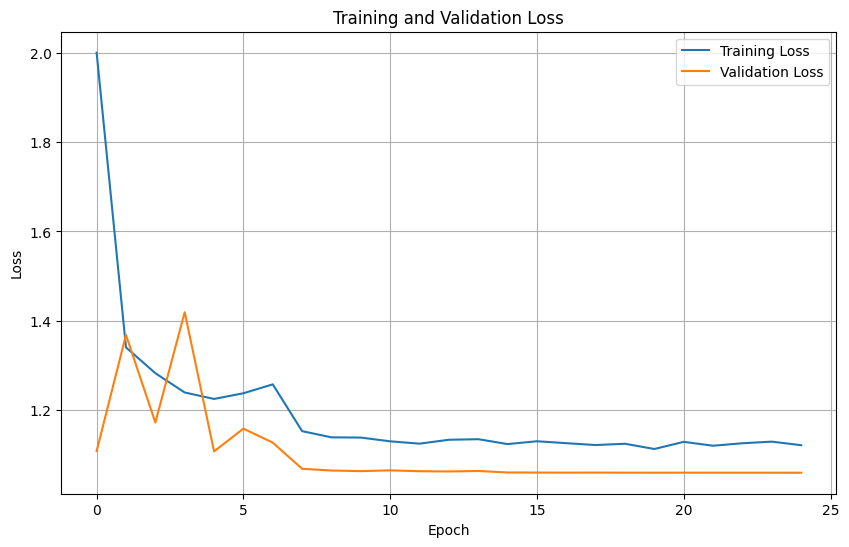

NameError: name 'all_metrics' is not defined

In [36]:
preTrainImageNet("squeezenet") # dermamnist 64x64

Fold:  0
Training:  262
Validation:  66


C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ishmu\anaconda3\envs\pyenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.8415 Acc: 0.6145
val Loss: 0.5274 Acc: 0.7576

Epoch 1/24
----------
train Loss: 0.4918 Acc: 0.8282
val Loss: 0.2886 Acc: 0.9242

Epoch 2/24
----------
train Loss: 0.3423 Acc: 0.8969
val Loss: 0.1671 Acc: 0.9697

Epoch 3/24
----------
train Loss: 0.2359 Acc: 0.9084
val Loss: 0.1380 Acc: 0.9545

Epoch 4/24
----------
train Loss: 0.2217 Acc: 0.9313
val Loss: 0.0936 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1742 Acc: 0.9466
val Loss: 0.0707 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1480 Acc: 0.9656
val Loss: 0.0700 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.1416 Acc: 0.9618
val Loss: 0.0615 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.1455 Acc: 0.9580
val Loss: 0.0652 Acc: 0.9697

Epoch 9/24
----------
train Loss: 0.1593 Acc: 0.9580
val Loss: 0.0594 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.1435 Acc: 0.9504
val Loss: 0.0566 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.1290 Acc: 0.9656
val Loss: 0.0541 Acc: 0.9848

Ep

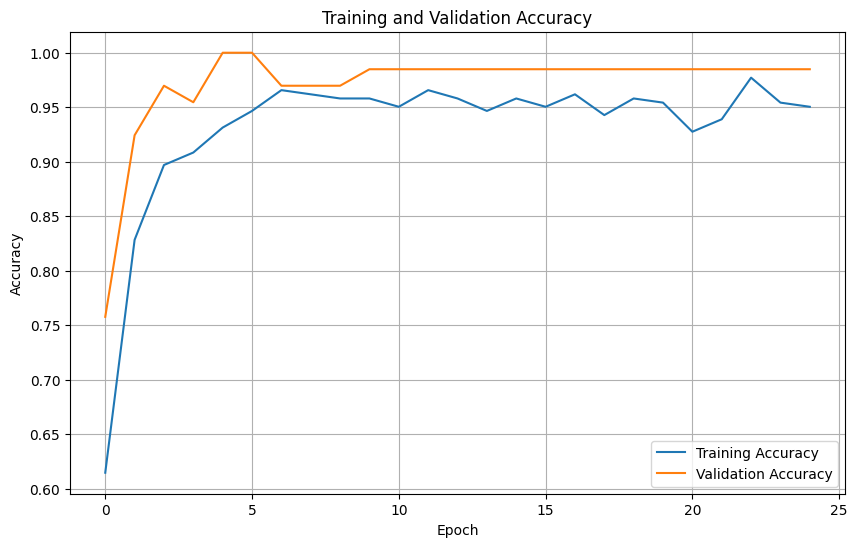

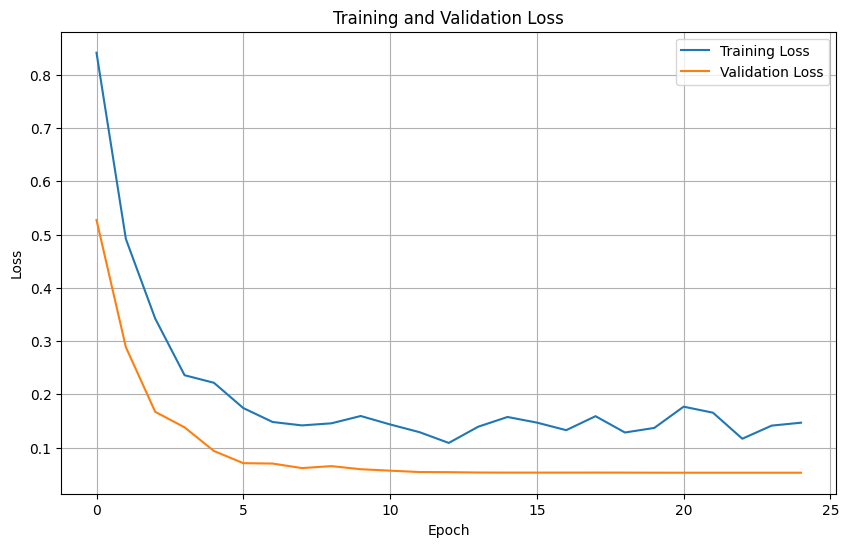

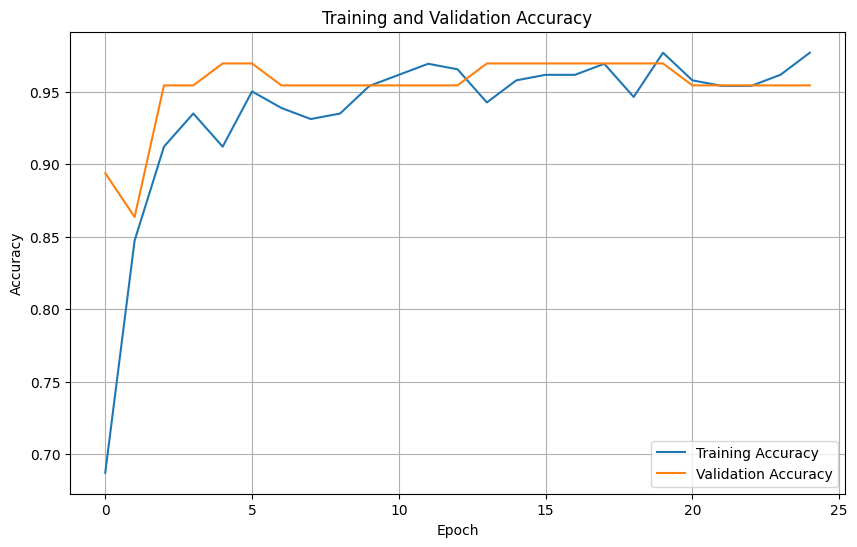

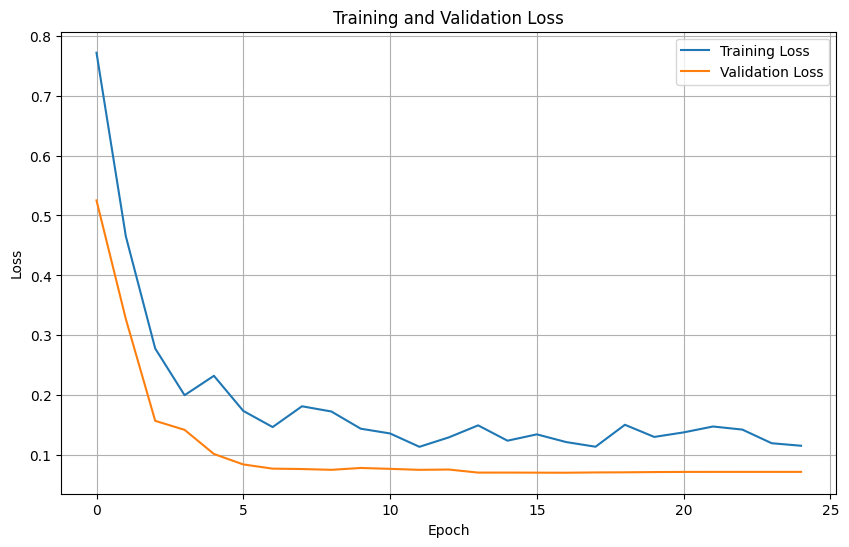

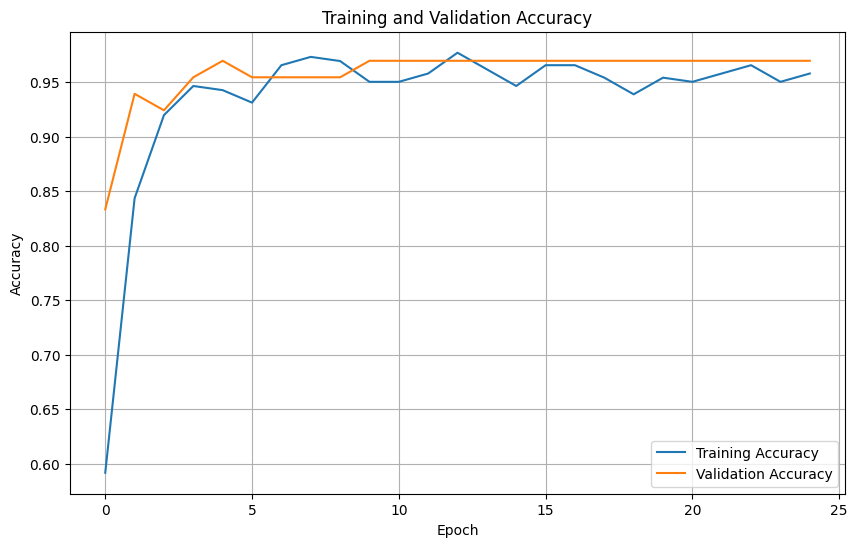

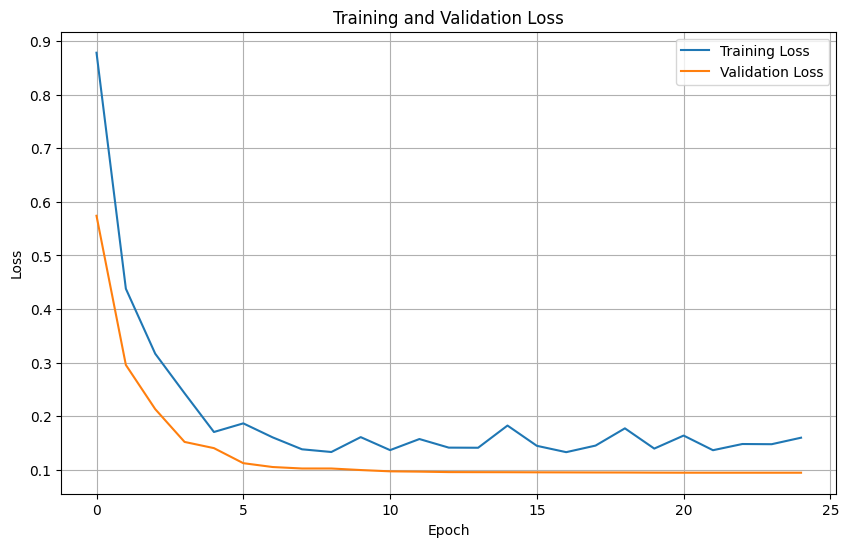

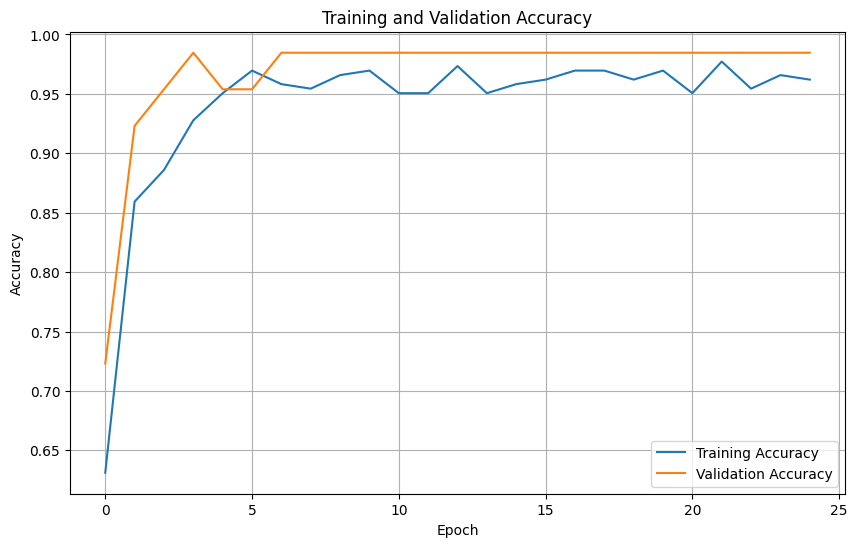

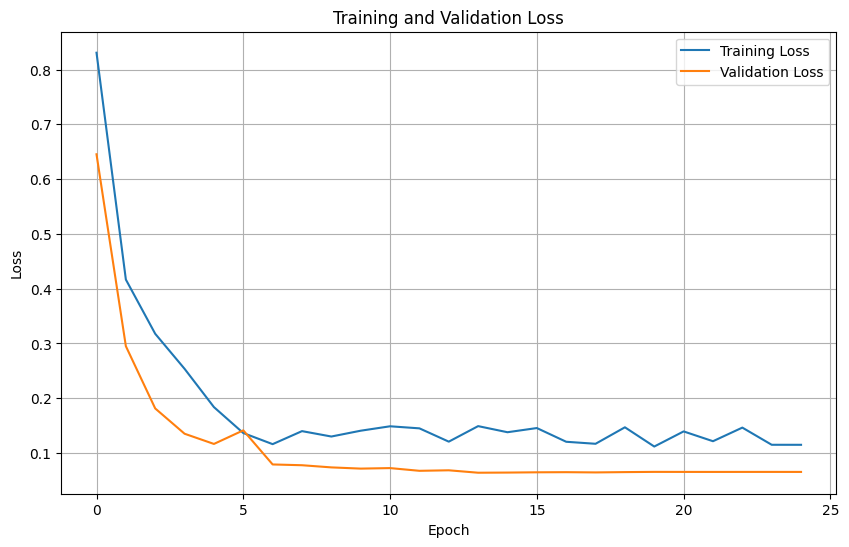

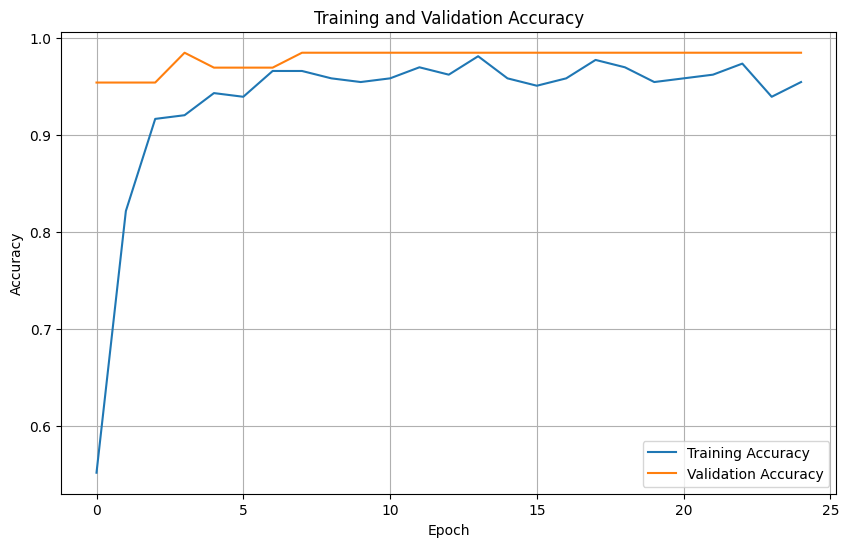

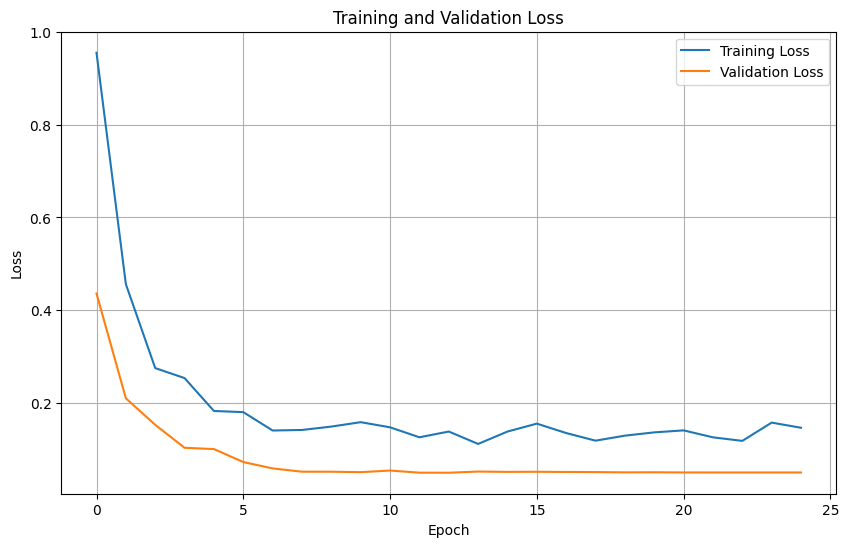

In [9]:
preTrainImageNet("squeezenet",classes) #THB dataset